# 경고! 실행중에 저장하면 프로그램 충돌인해 계속해서 작업만 수행함.

# 9.

*문제: (3장에서 소개한) MNIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할합니다(처음 60,000개는 훈련을 위한 샘플이고 나머지 10,000개는 테스트용입니다).*

앞서 로드한 MNIST 데이터셋을 사용합니다.

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [2]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

*문제: 이 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가합니다.*

In [3]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [4]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [5]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 43.35s


In [6]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

*문제: 그런 다음 PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소합니다.*

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*문제: 이 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인합니다. 훈련 속도가 더 빨라졌나요?*

In [8]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [9]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 97.58s


이런! 훈련이 두 배 이상 느려졌습니다! 어떻게 이럴 수 있죠? 이 장에서 보았듯이 차원 축소는 언제나 훈련 시간을 줄여주지 못합니다. 데이터셋, 모델, 훈련 알고리즘에 따라 달라집니다. 그림 8-6(위에 있는 `manifold_decision_boundary_plot*` 그래프)을 참고하세요. 랜덤 포레스트 분류기 대신 소프트맥스 분류기를 적용하면 PCA를 사용해서 훈련 시간을 3배나 줄일 수 있습니다. 잠시 후에 실제로 한번 해보겠습니다. 하지만 먼저 새로운 랜덤 포레스트 분류기의 정밀도를 확인해 보죠.

*문제: 이제 테스트 세트에서 이 분류기를 평가해보세요. 이전 분류기와 비교해서 어떤가요?*

In [10]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

차원 축소를 했을 때 유용한 정보를 일부 잃었기 때문에 성능이 조금 감소되는 것이 일반적입니다. 그렇지만 이 경우에는 성능 감소가 좀 심각한 것 같습니다. PCA가 별로 도움이 되지 않네요. 훈련 시간도 느려지고 성능도 감소했습니다. :(

소프트맥스 회귀를 사용하면 도움이 되는지 확인해 보겠습니다:

In [11]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 19.09s


In [13]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

좋네요. 소프트맥스 회귀는 랜덤 포레스트 분류기보다 이 데이터셋에서 훈련하는데 더 많은 시간이 걸리고 테스트 세트에서의 성능도 더 나쁩니다. 하지만 지금 관심 사항은 아닙니다. PCA가 소프트맥스 회귀에 얼마나 도움이 되는지가 궁금합니다. 축소된 데이터셋에 소프트맥스 회귀 모델을 훈련시켜 보겠습니다:

In [14]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 8.12s


와우! 차원 축소가 속도를 2배 이상 빠르게 만들었습니다. :) 모델의 정확도를 확인해 보겠습니다:

In [16]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

성능이 조금 감소되었지만 애플리케이션에 따라서 2배 이상의 속도 향상에 대한 댓가로 적절한 것 같습니다.

여기서 알 수 있는 것: PCA는 속도를 아주 빠르게 만들어 주지만 항상 그런 것은 아니다!

# 10.

*문제: t-SNE 알고리즘을 사용해 MNIST 데이터셋을 2차원으로 축소시키고 맷플롯립으로 그래프를 그려보세요. 이미지의 타깃 클래스마다 10가지 색깔로 나타낸 산점도를 그릴 수 있습니다.*

전체 60,000개의 이미지에 차원 축소를 하면 매우 오랜 시간이 걸리므로 10,000개의 이미지만 무작위로 선택하여 사용하겠습니다:

In [17]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [18]:
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

이제 t-SNE를 사용해 2D로 차원을 축소해 그래프로 나타냅니다:

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


산점도를 그리기 위해 맷플롯립의 `scatter()` 함수를 사용합니다. 각 숫자마다 다른 색깔을 사용합니다:

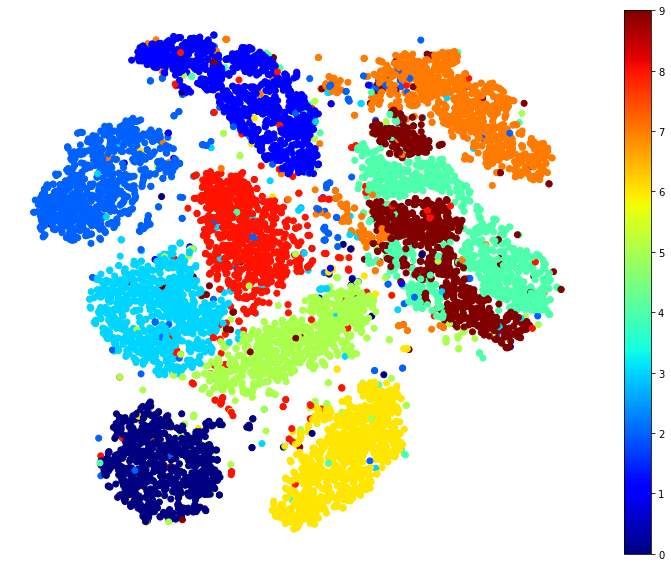

In [20]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

아름답지 않나요? :) 이 그래프는 어떤 숫자가 다른 것과 구분이 쉬운지 알려 줍니다(가령, 0, 6, 8이 잘 구분되어 있습니다). 그리고 어떤 숫자가 구분이 어려운지 알려 줍니다(가령, 4, 9, 5, 3 등입니다).

많이 겹쳐진 것 같은 숫자 2, 3, 5에 집중해 보겠습니다.

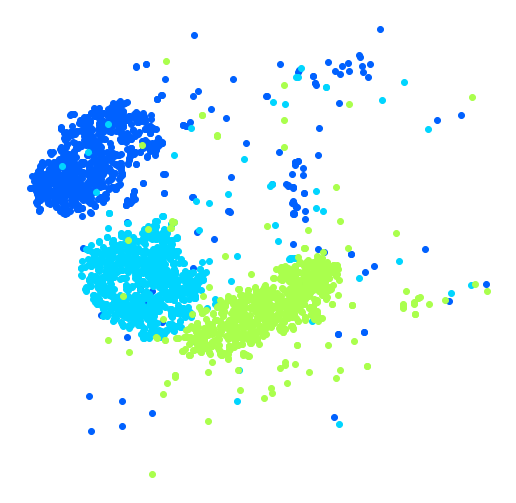

In [21]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

이 3개의 숫자에 t-SNE를 실행시켜 더 나은 이미지를 만들 수 있는지 보겠습니다:

In [22]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


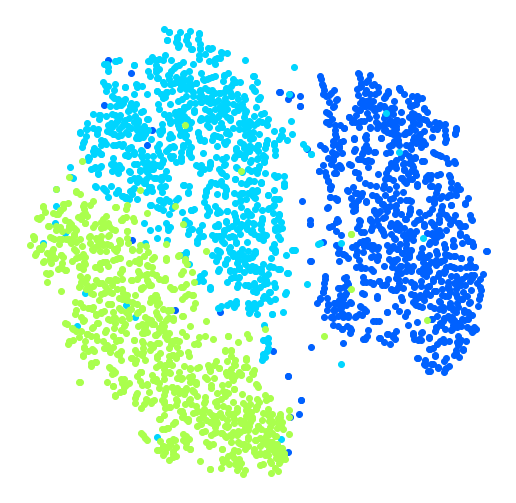

In [23]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

훨씬 좋네요. 이제 군집이 덜 겹쳐졌습니다. 하지만 숫자 3이 여러 군데 흩어져 있습니다. 또한 2와 5의 군집은 두개로 보입니다. 각 군집에 숫자를 몇 개씩 나타내면 이런 이유를 훨씬 이해하는기 좋습니다. 그렇게 한번 해보죠.

*문제: 또는 샘플의 위치에 각기 다른 색깔의 숫자를 나타낼 수도 있고, 숫자 이미지 자체의 크기를 줄여서 그릴 수도 있습니다(모든 숫자를 다 그리면 그래프가 너무 복잡해지므로 무작위로 선택한 샘플만 그리거나, 인접한 곳에 다른 샘플이 그려져 있지 않은 경우에만 그립니다). 잘 분리된 숫자의 군집을 시각화할 수 있을 것입니다.*

(위에 있는 산점도와 비슷하게) 산점도와 색깔있는 숫자를 쓰기위해 `plot_digits()` 함수를 만듭니다. 이 숫자 사이의 거리가 최소가 되도록 합니다. 숫자 이미지가 있다면 대신 이를 사용합니다. 이 코드는 사이킷런의 훌륭한 데모([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), 데이터셋은 다릅니다)를 참고했습니다.

In [24]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # 입력 특성의 스케일을 0에서 1 사이로 만듭니다.
    X_normalized = MinMaxScaler().fit_transform(X)
    # 그릴 숫자의 좌표 목록을 만듭니다.
    # 반복문 아래에서 `if` 문장을 쓰지 않기 위해 시작할 때 이미 그래프가 그려져 있다고 가정합니다.
    neighbors = np.array([[10., 10.]])
    # 나머지는 이해하기 쉽습니다.
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # 현재 그래프의 축을 가져옵니다.
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

시작해 보죠! 먼저 색깔이 입혀진 숫자를 써 보겠습니다:

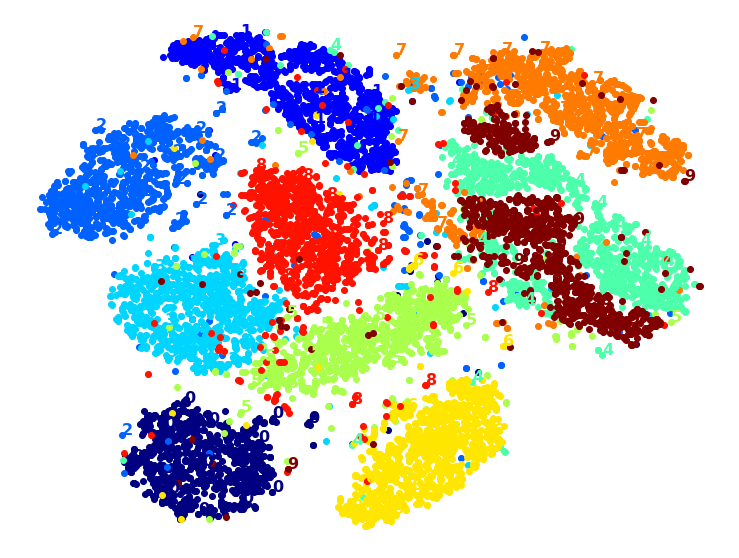

In [25]:
plot_digits(X_reduced, y)

꽤 좋습니다. 하지만 아름답지는 않네요. 숫자 이미지를 사용해 보겠습니다:

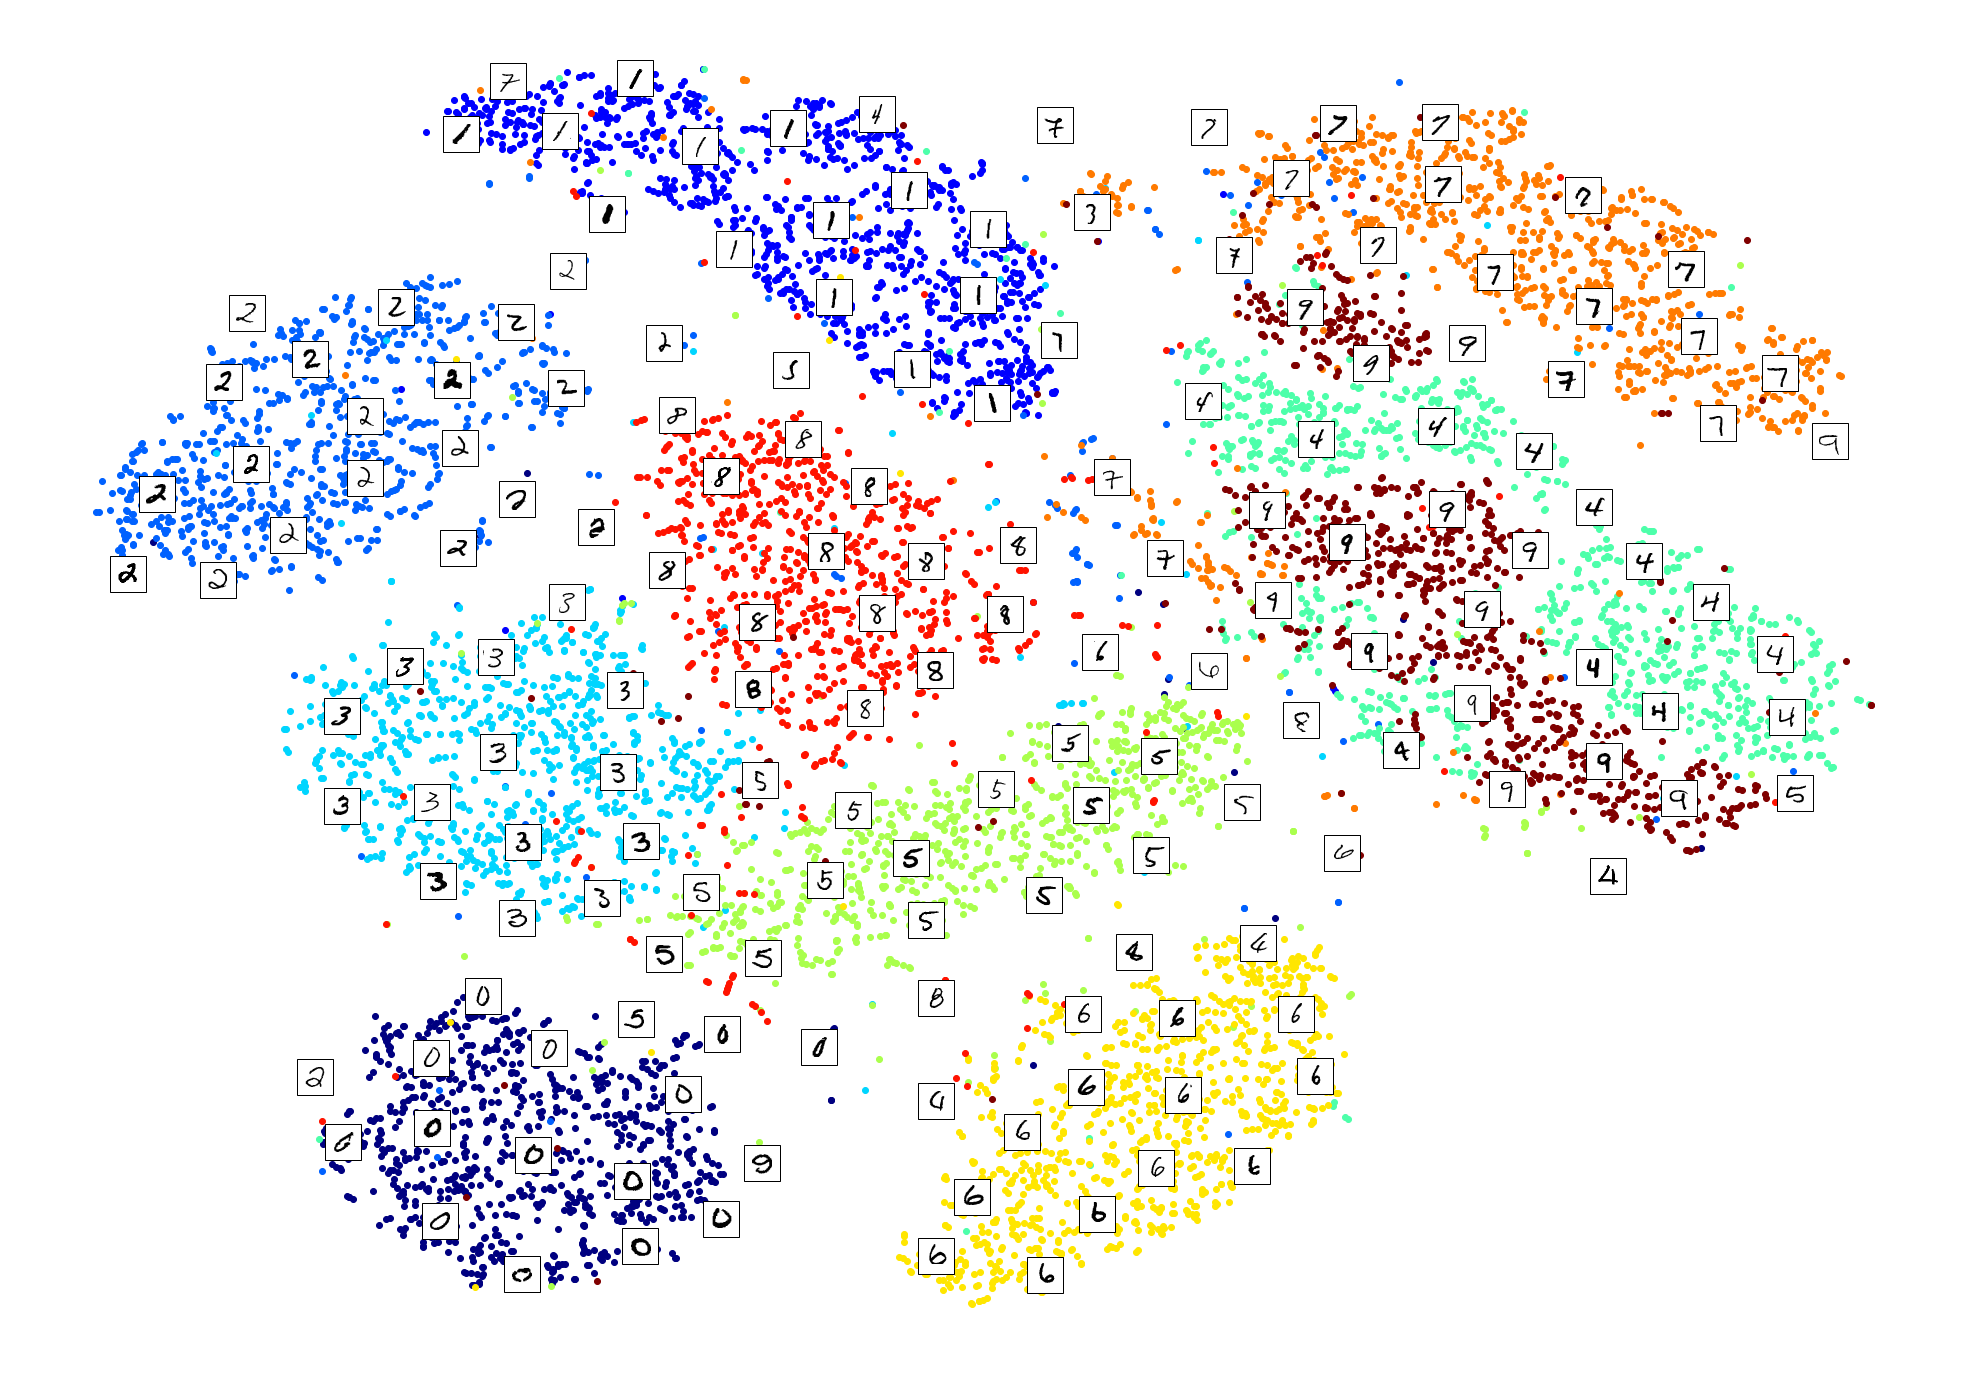

In [26]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

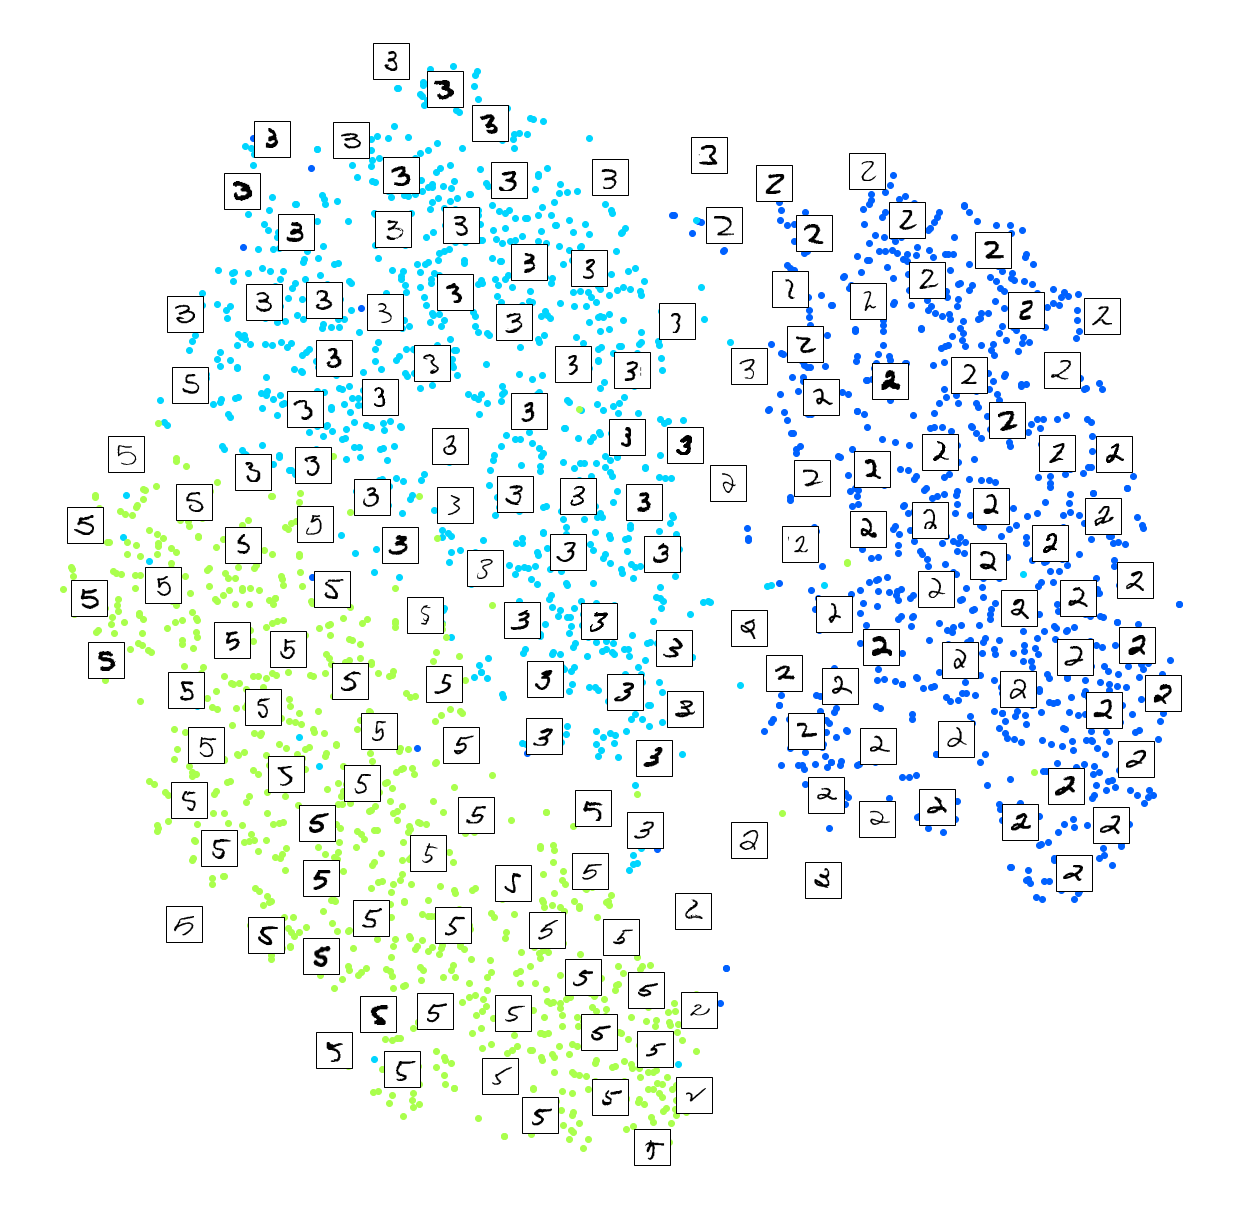

In [27]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*문제: PCA, LLE, MDS 같은 차원 축소 알고리즘을 적용해보고 시각화 결과를 비교해보세요.*

PCA부터 시작해 보죠. 얼마나 오래 걸리는지도 재어 보겠습니다:

PCA 시간: 0.2s.


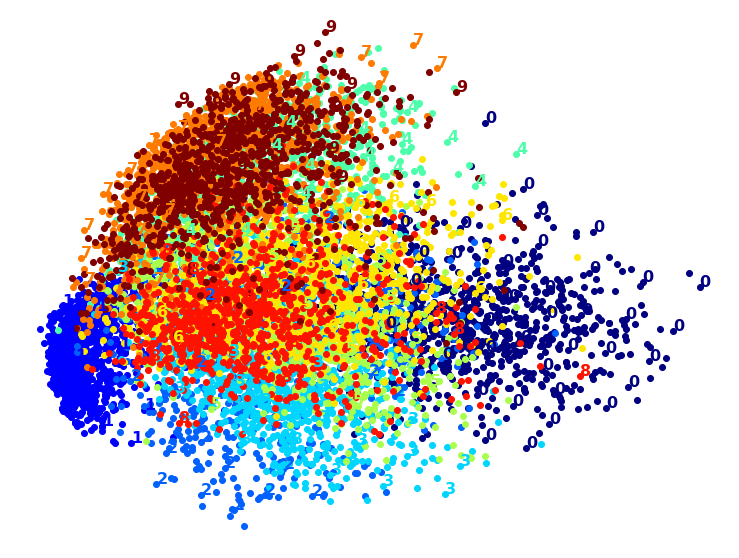

In [28]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

와우, PCA가 아주 빠르네요! 몇 개의 군집이 보이지만 너무 겹쳐져 있습니다. LLE를 사용해 보죠:

LLE 시간: 16.9s.


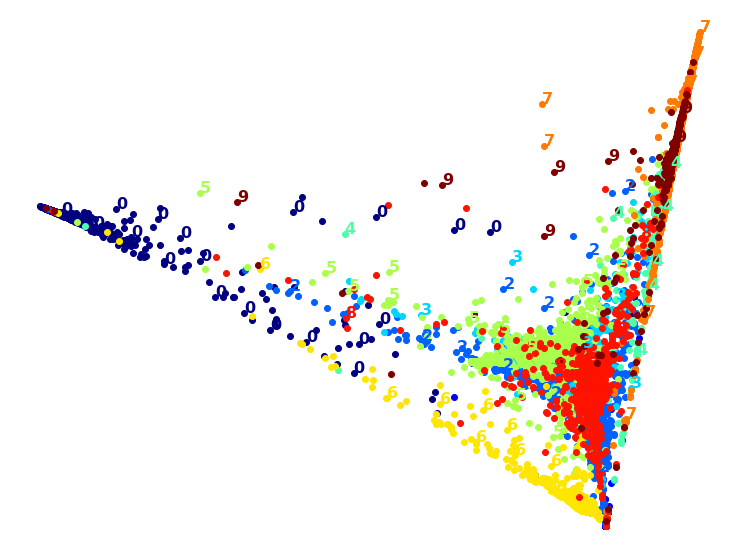

In [29]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

시간이 좀 걸리고 결과도 아주 좋지는 않습니다. 분산의 95%를 보존하도록 먼저 PCA를 적용하면 어떻게 되는지 보겠습니다:

PCA+LLE 시간: 15.4s.


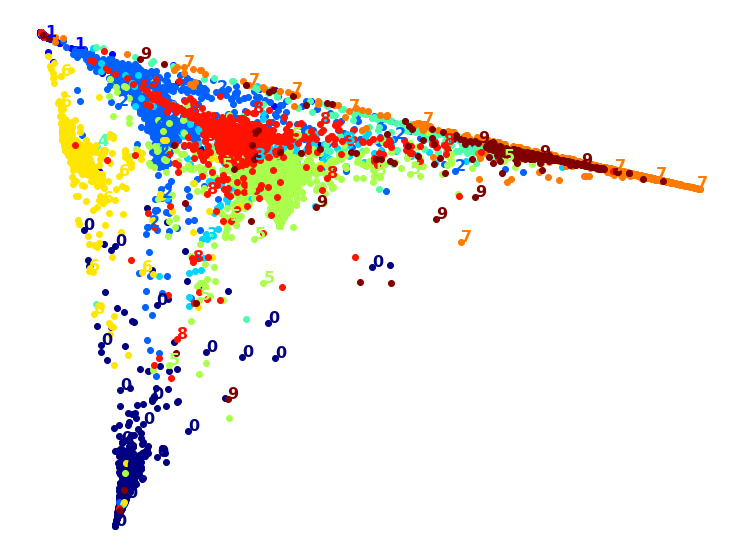

In [30]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

결과는 비슷하지만 걸린 시간은 4배나 줄었습니다.

MDS를 시도해 보죠. 10,000개 샘플을 적용하면 이 알고리즘은 너무 오래걸리므로 2,000개만 시도해 보겠습니다:

MDS 시간 126.6s (on just 2,000 MNIST images instead of 10,000).


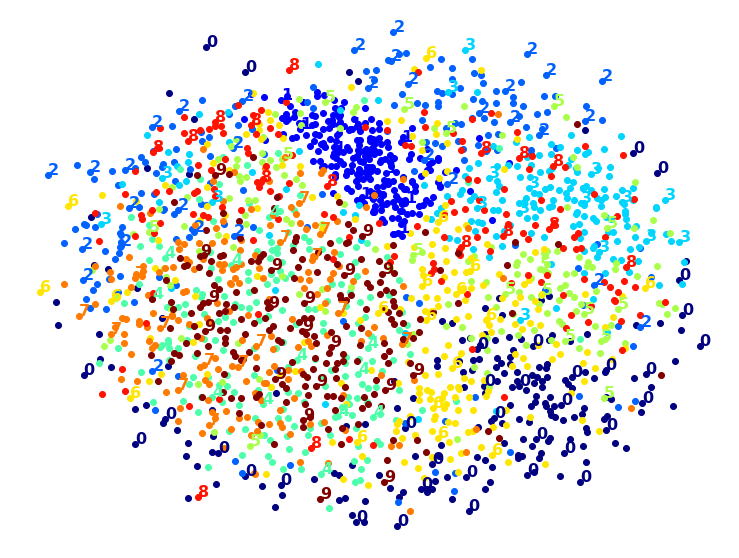

In [31]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS 시간 {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

아 이건 좋지 않아 보이네요. 모든 군집이 너무 중복되어 있습니다. 먼저 PCA를 적용하면 빨라질까요?

PCA+MDS 시간 129.0s (on 2,000 MNIST images).


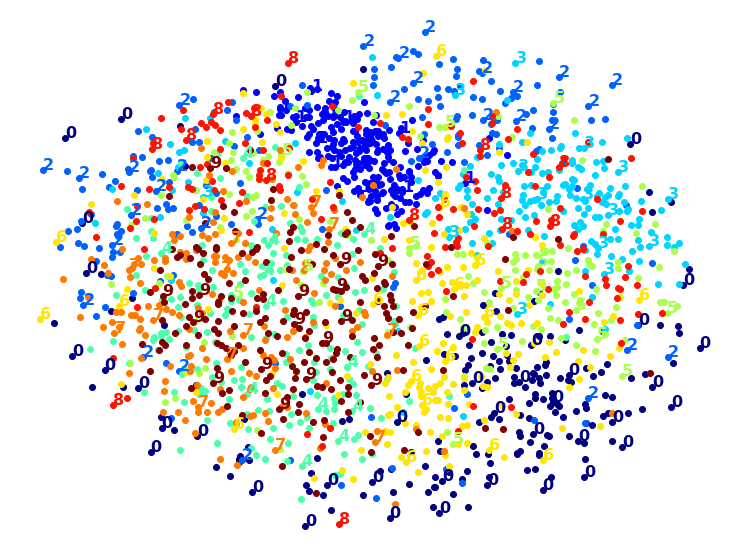

In [32]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS 시간 {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

같은 결과에 속도도 동일합니다. PCA가 도움이 되지 않네요.

LDA를 시도해 보죠:

LDA 시간 2.1s.


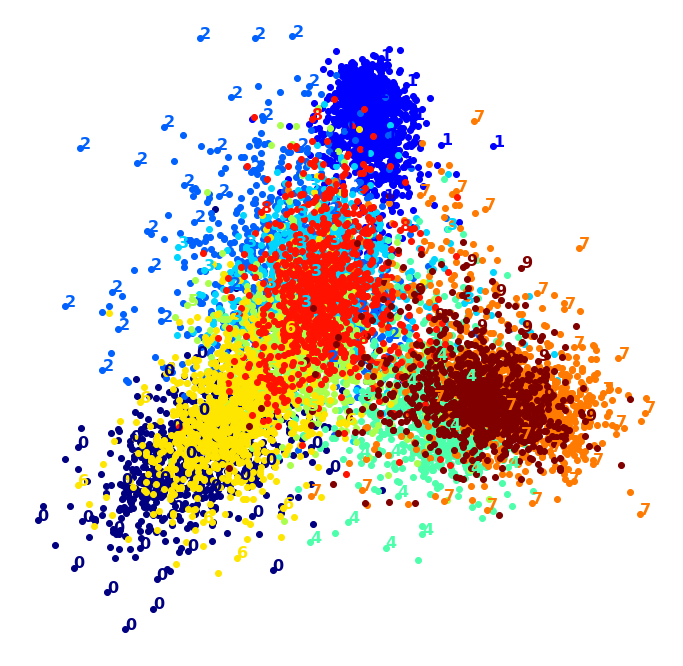

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

매우 빨라 처음엔 괜찮아 보이지만 자세히 보면 몇 개의 군집이 심각하게 중복되어 있습니다.

아마 이 비교에서 t-SNE가 승자같네요. 시간을 재어 보진 않았으니 한번 해보죠:

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE 시간 43.9s.


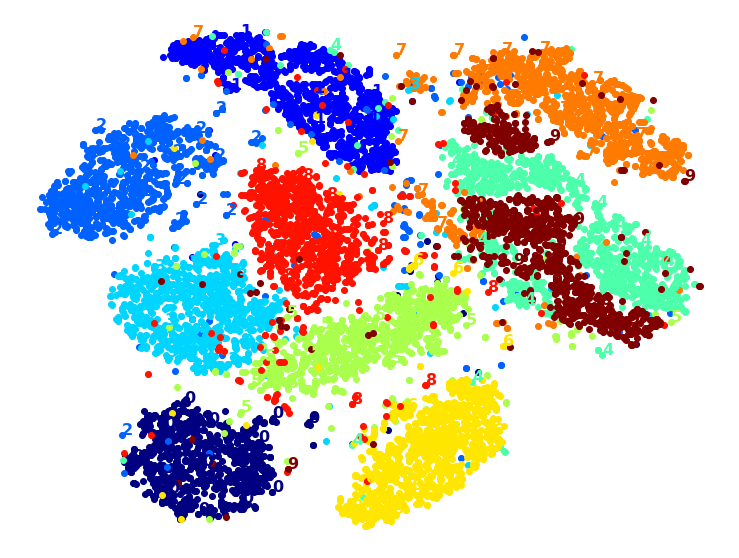

In [34]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

LLE 보다 두 배나 느립니다. 하지만 MDS 보단 훨씬 빠르고 결과물도 아주 좋습니다. PCA가 속도를 높여줄 수 있는지 확인해 보겠습니다:

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA+t-SNE 시간 43.8s.


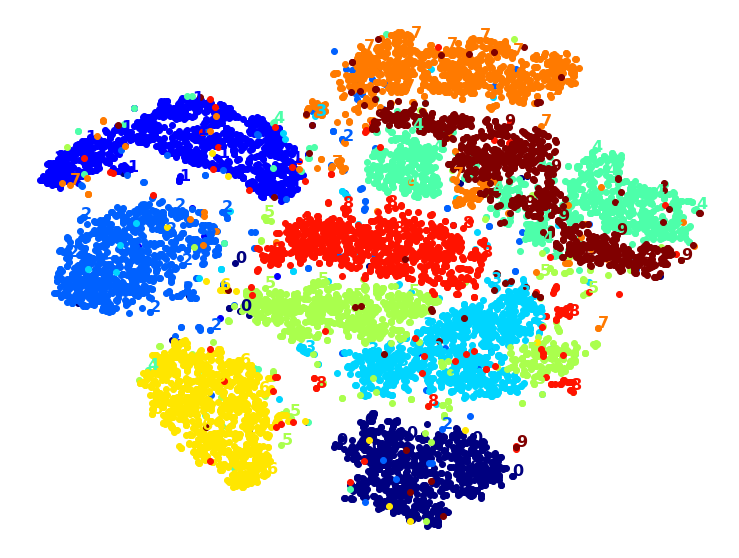

In [35]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

네, 결과물에 영향을 미치지 않으면서 PCA 속도가 2배 이상 정도 향상되었습니다. 이것이 제일 좋네요!